In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold



## Testing with GradientBoost from XGBoost

In [ ]:
df = pd.read_csv('../dataset/train_data.csv')

In [ ]:
df

,Driver,Qualifying_Time,Race_Time,LapNumber,Position,Compound,TyreLife,Weather_AirTemp,Weather_TrackTemp,Weather_Humidity,Weather_WindSpeed,Weather_Rainfall,Weather_Pressure,team,FP1_total_time,FP2_total_time,FP3_total_time,Year,EventName
0,ALB,90.474,110.771,1.0,15.0,MEDIUM,1.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
1,ALB,90.474,100.750,2.0,15.0,MEDIUM,2.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
2,ALB,90.474,99.762,3.0,15.0,MEDIUM,3.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
3,ALB,90.474,99.285,4.0,15.0,MEDIUM,4.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
4,ALB,90.474,99.252,5.0,15.0,MEDIUM,5.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55739,ZHO,78.072,81.835,66.0,16.0,MEDIUM,24.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix
55740,ZHO,78.072,82.056,67.0,16.0,MEDIUM,25.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix
55741,ZHO,78.072,81.826,68.0,16.0,MEDIUM,26.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix
55742,ZHO,78.072,83.604,69.0,15.0,MEDIUM,27.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix


In [ ]:
# Drop Race_Time column
X = df.drop(columns=['Race_Time'])
y = df['Race_Time']

categorical_features = X.select_dtypes(include=['object']).columns
for col in categorical_features:
    X[col] = X[col].astype('category')
    


In [ ]:
df_test = pd.read_csv('../dataset/test_data_2025.csv')

In [ ]:
# Train/test split
features = X.columns.tolist()
features.remove('Weather_Pressure')
X_train = X[features]
y_train = y
X_test = df_test[features]

for col in categorical_features:
    if col in features:
        X_test[col] = X_test[col].astype('category')
        X_test[col] = X_test[col].cat.set_categories(X[col].cat.categories)

# drop row with unseen categories in X_test
X_test = X_test[X_test.apply(lambda row: all(row[col] in X[col].cat.categories for col in categorical_features if col in features), axis=1)]
y_test = df_test.loc[X_test.index, 'Race_Time']

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.005, 0.01, 0.02, 0.03],
    'max_depth': [1, 2, 3],
    'reg_alpha': [100, 200, 300],
    'reg_lambda': [20, 50, 80],
    'min_child_weight': [1, 5, 10, 20],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0, 1.2]
}
# Train the model
xgb_search = XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror',
    random_state=42
)

search = RandomizedSearchCV(
    xgb_search,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Make sure categorical columns are of type 'category'
for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')

search.fit(X_train, y_train)

print("Best parameters found:", search.best_params_)
print("Best CV MAE:", -search.best_score_)


C:\Users\khanh\AppData\Local\Temp\ipykernel_44056\79726104.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')
C:\Users\khanh\AppData\Local\Temp\ipykernel_44056\79726104.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].cat.set_categories(X[col].cat.categories)
C:\Users\khanh\AppData\Local\Temp\ipykernel_44056\79726104.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\xgboost\sklearn.py", line 1368, in fit
    self._Booster = train(
          

Best parameters found: {'subsample': 0.7, 'reg_lambda': 80, 'reg_alpha': 200, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV MAE: 7.1652365926018815


[0]	validation_0-mae:11.32247	validation_1-mae:11.12373
[10]	validation_0-mae:10.67916	validation_1-mae:10.45268
[20]	validation_0-mae:10.10884	validation_1-mae:9.87167
[30]	validation_0-mae:9.59081	validation_1-mae:9.34359
[40]	validation_0-mae:9.13711	validation_1-mae:8.89022
[50]	validation_0-mae:8.72494	validation_1-mae:8.47363
[60]	validation_0-mae:8.34836	validation_1-mae:8.12289
[70]	validation_0-mae:8.01805	validation_1-mae:7.82691
[80]	validation_0-mae:7.71609	validation_1-mae:7.54865
[90]	validation_0-mae:7.43832	validation_1-mae:7.28606
[100]	validation_0-mae:7.20002	validation_1-mae:7.06864
[110]	validation_0-mae:6.99224	validation_1-mae:6.87956
[120]	validation_0-mae:6.80764	validation_1-mae:6.70995
[130]	validation_0-mae:6.63919	validation_1-mae:6.55707
[140]	validation_0-mae:6.48290	validation_1-mae:6.43017
[150]	validation_0-mae:6.34903	validation_1-mae:6.30581
[160]	validation_0-mae:6.23431	validation_1-mae:6.22219
[170]	validation_0-mae:6.12235	validation_1-mae:6.1130

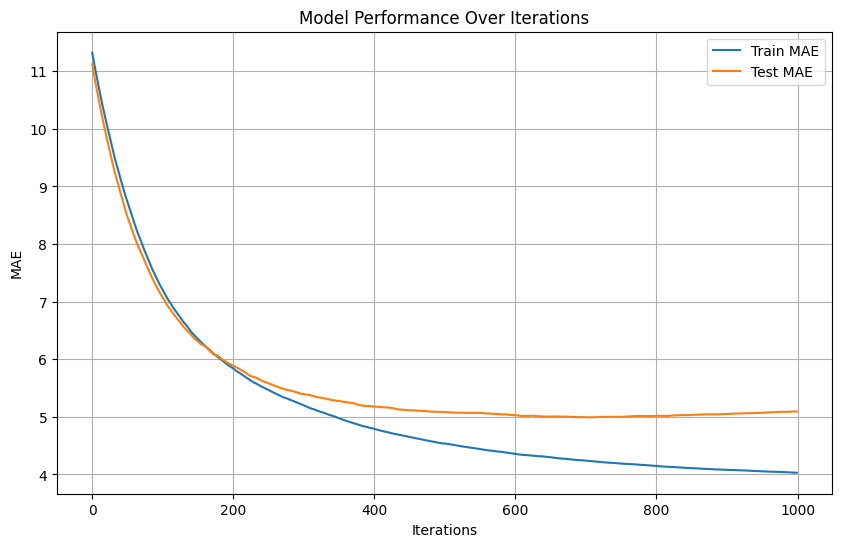

In [ ]:
best_params = search.best_params_

# Retrain with eval_set to get evals_result
final_model = XGBRegressor(
    **best_params,
    enable_categorical=True,
    objective='reg:squarederror',
    random_state=42,
    eval_metric='mae'
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
)

results = final_model.evals_result()
# Plot training and validation error
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Train MAE')
plt.plot(results['validation_1']['mae'], label='Test MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Model Performance Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

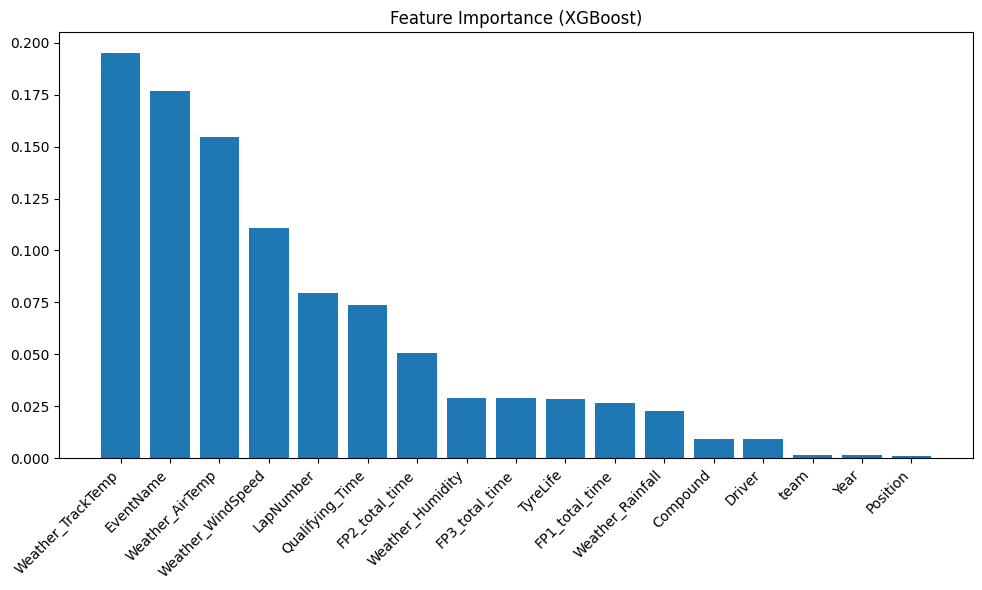

Top features by importance:
Weather_TrackTemp: 0.1952
EventName: 0.1767
Weather_AirTemp: 0.1547
Weather_WindSpeed: 0.1106
LapNumber: 0.0796
Qualifying_Time: 0.0739
FP2_total_time: 0.0508
Weather_Humidity: 0.0291
FP3_total_time: 0.0288
TyreLife: 0.0286


In [ ]:
# Get feature importances (gain-based by default)
importances = final_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (XGBoost)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print top features
print("Top features by importance:")
for i in indices[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

In [ ]:
df_test = pd.read_csv('../dataset/test_data_2025.csv')

In [ ]:
X_test = df_test.drop(columns=['Race_Time'])
for col in categorical_features:
    X_test[col] = X_test[col].astype('category')

y_test = df_test['Race_Time']

if (X.columns == X_test.columns).all():
    print("Features match between training and test sets.")

for col in categorical_features:
    X_test[col] = X_test[col].astype('category')
    X_test[col] = X_test[col].cat.set_categories(X[col].cat.categories)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Set MAE: {mae:.4f} seconds")

# plot actual vs predicted

Features match between training and test sets.
Test Set MAE: 9.6323 seconds


In [ ]:
# Label Encoder for comparison
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_le = X.drop(columns=['FP2_total_time']).copy()
for col in categorical_features:
    X_le[col] = le.fit_transform(X_le[col])

# Drpp NaN values
X_le = X_le.dropna()
y_le = y.loc[X_le.index]
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(X_le, y_le, test_size=0.2, random_state=42) 

In [ ]:
# Grandient Boosting Regressor for comparison
gbr_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
gbr_model.fit(X_train_le, y_train_le)
y_pred_gbr = gbr_model.predict(X_test_le)
rmse_gbr = np.sqrt(mean_squared_error(y_test_le, y_pred_gbr))
mae_gbr = mean_absolute_error(y_test_le, y_pred_gbr)
r2_gbr = r2_score(y_test_le, y_pred_gbr)
print("\nGradient Boosting Regressor with Label Encoding:")
print(f"RMSE: {rmse_gbr:.4f} seconds")
print(f"MAE: {mae_gbr:.4f} seconds")
print(f"R² Score: {r2_gbr:.4f}")



Gradient Boosting Regressor with Label Encoding:
RMSE: 20.0406 seconds
MAE: 4.2355 seconds
R² Score: 0.9183


In [ ]:
# Random Forest Regressor for comparison
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf_model.fit(X_train_le, y_train_le)
y_pred_rf = rf_model.predict(X_test_le)
rmse_rf = np.sqrt(mean_squared_error(y_test_le, y_pred_rf))
mae_rf = mean_absolute_error(y_test_le, y_pred_rf)
r2_rf = r2_score(y_test_le, y_pred_rf)
print("\nRandom Forest Regressor with Label Encoding:")
print(f"RMSE: {rmse_rf:.4f} seconds")
print(f"MAE: {mae_rf:.4f} seconds")
print(f"R² Score: {r2_rf:.4f}")



Random Forest Regressor with Label Encoding:
RMSE: 25.6930 seconds
MAE: 3.5253 seconds
R² Score: 0.8657


In [ ]:
# CatBoost Regressor for comparison
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=3,
    random_seed=42,
    verbose=0,
    cat_features=list(categorical_features)
)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
mae_cat = mean_absolute_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)
print("\nCatBoost Regressor with Categorical Features:")
print(f"RMSE: {rmse_cat:.4f} seconds")
print(f"MAE: {mae_cat:.4f} seconds")
print(f"R² Score: {r2_cat:.4f}")


CatBoostError: Invalid type for cat_feature[object_idx=29,feature_idx=4]=NaN : cat_features must be integer or string, real number values and NaN values should be converted to string.